In [34]:
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms
from tqdm import tqdm

In [33]:
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 284.3 kB/s eta 0:00:001m178.6 kB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 1.2 MB/s eta 0:00:001.0 MB/s eta 0:00:01


In [2]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [4]:
class ImageTransform:
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)

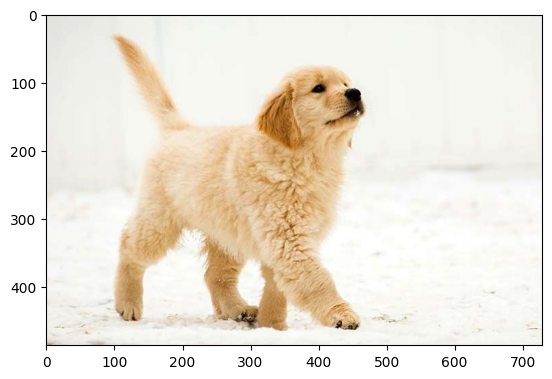

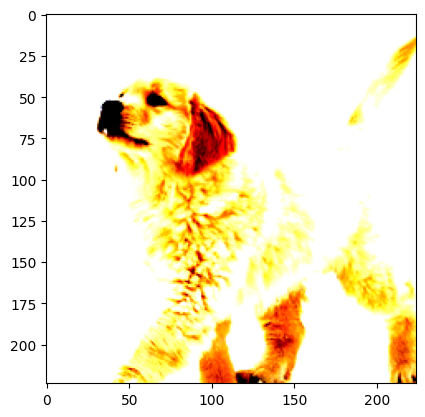

In [5]:
img_file_path = "./data/dof.jpg"
img = Image.open(img_file_path)

plt.imshow(img)
plt.show()

resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(resize, mean, std)
img_transformed = transform(img, phase='train')

# (channels, height, width) -> (height, width, channels) -> (0, 1)
img_transformed = img_transformed.numpy().transpose(1, 2, 0)
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [6]:
def make_datapath_list(phase='train'):
    rootpath = "./data/hymenoptera_data/"
    target_path = osp.join(rootpath+phase+"/**/*.jpg")

    path_list = []

    for path in glob.glob(target_path):
        path_list.append(path)
    return path_list

In [7]:
path_list = make_datapath_list("train")
len(path_list)

243

In [8]:
train_list = make_datapath_list("train")
val_list = make_datapath_list("val")

In [9]:
class MyDataset(data.Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)

        img_transformed = self.transform(img, self.phase)

        if self.phase == 'train':
            label = img_path[30:34] 
        elif self.phase == 'val':
            label = img_path[28:32]

        label = 0 if label=="ants" else 1
        return img_transformed, label

In [10]:
train_dataset = MyDataset(train_list, transform=ImageTransform(resize, mean, std), phase="train")

In [11]:
val_dataset = MyDataset(val_list, transform=ImageTransform(resize, mean, std), phase="val")

In [12]:
index = 0
# print(train_dataset.__len__())
img, label = train_dataset.__getitem__(index)
print(img.shape, label)

torch.Size([3, 224, 224]) 1


In [16]:
batch_size = 4
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)

dataloader_dict = {
    "train": train_dataloader,
    "val": val_dataloader
}

In [17]:
batch_iterator = iter(dataloader_dict['train'])
inputs, labels = next(batch_iterator)

In [18]:
print(inputs.shape)
print(labels)

torch.Size([4, 3, 224, 224])
tensor([0, 1, 0, 1])


### Network

In [19]:
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)

net.classifier[6] = nn.Linear(in_features=4096, out_features=2, bias=True)

# setting mode
net.train()

/home/nguyen/anaconda3/envs/deep-learning/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nguyen/anaconda3/envs/deep-learning/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### loss

In [20]:
criterior = nn.CrossEntropyLoss()

### optimizer

In [21]:
params_to_update = []

update_params_name = ["classifier.6.weight", "classifier.6.bias"]

for name, param in net.named_parameters():
    if name in update_params_name:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False
print(params_to_update)

classifier.6.weight
classifier.6.bias
[Parameter containing:
tensor([[-0.0125,  0.0072, -0.0067,  ..., -0.0117, -0.0064, -0.0095],
        [ 0.0136, -0.0033,  0.0122,  ...,  0.0106,  0.0072,  0.0012]],
       requires_grad=True), Parameter containing:
tensor([-0.0074, -0.0002], requires_grad=True)]


In [22]:
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

In [37]:
def train_model(net, dataloader_dict, criterior, optimizer, num_epochs):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs}")
        for phase in ["train", "val"]:
            if phase == "train":
                net.train()
            else:
                net.eval()
            epoch_loss = 0.0
            epoch_corrects = 0

        if epoch == 0 and phase == "train":
            continue
        for inputs, labels in tqdm(dataloader_dict[phase]):
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == "train"):
                outputs = net(inputs)
                loss = criterior(outputs, labels)
                _, preds = torch.max(outputs, 1)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                epoch_loss += loss.item()*inputs.size(0)
                epoch_corrects += torch.sum(preds==labels)

        epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
        epoch_accuracy = epoch_corrects.double() / len(dataloader_dict[phase].dataset)

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_accuracy:.4f}")

In [38]:
num_epoch = 2
train_model(net, dataloader_dict, criterior, optimizer, num_epoch)

Epoch 0/2


100%|█████████████████████████████████████████████████████| 39/39 [00:28<00:00,  1.38it/s]


val Loss: 0.7870 Acc: 0.4510
Epoch 1/2


100%|█████████████████████████████████████████████████████| 39/39 [00:24<00:00,  1.60it/s]

val Loss: 0.7870 Acc: 0.4510
